# Label the training dataset

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
pd.set_option('max_colwidth', 140)

In [2]:
dataset = "../train.json"
df = pd.read_json(dataset,lines=True)

MemoryError: 

In [97]:
# Peel out count of helpful votes into its own column
df['helpful_votes'] = df.apply(lambda x: x.helpful[0],axis=1)
# To avoid confusion later, drop the 'helpful' column at this point
df.drop('helpful', axis = 1, inplace=True)
# Convert reviewTime to datetime type info we can work with
df.reviewTime = pd.to_datetime(df.reviewTime,infer_datetime_format=True)

In [98]:
print("Our dataset initially contains {} reviews".format(df.shape[0]))

Our dataset initially contains 37722 reviews


In [99]:
# Our dataset snapshot has as its maximum review date 2014-07-23
snapshotted_string = "20140723"
snapshotted = datetime.datetime.strptime(snapshotted_string, '%Y%m%d')

# We will DROP reviews less than one year old
# They may not have accumulated enough evidence to support being helpful or not
ourcutoff = snapshotted - datetime.timedelta(days=365)
df = df[df.reviewTime < ourcutoff]
print("After removing reviews less than one year old, our dataset contains {} reviews".format(df.shape[0]))

After removing reviews less than one year old, our dataset contains 28567 reviews


In [100]:
# Here we store the age of each review in days
df['review_age_days'] = df.apply(lambda x: (snapshotted - x.reviewTime).days,axis = 1)

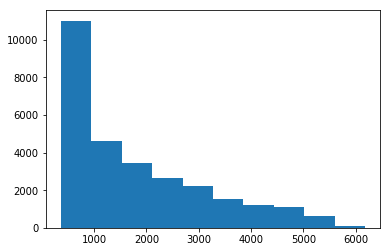

In [101]:
days_old_hist = plt.hist(df['review_age_days'])

In [102]:
# We create the annual HVAR score
df['annual_HVAR'] = df.apply(lambda x: 365*x.helpful_votes/x.review_age_days, axis = 1)

In [103]:
# Now we group by the book id
# And aggregate by count of unique reviews for the given book
# (We count using unixReviewTime as a proxy for uniqueness because there's no review ID provided)
# We also aggregate the HVAR within groups by its standard deviation
# As we cannot retrieve a signal with respect to helpfulness if reviews don't have variance 
by_book = df.groupby('asin').agg({'unixReviewTime':'size','annual_HVAR': lambda x: (x.std(),x.quantile(.75))})

In [104]:
# Extract standard deviation to filter out zero-valued books later
by_book['std_HVAR'] = by_book.apply(lambda x: x.annual_HVAR[0],axis = 1)
# Extract top quartile cutoff per book
by_book['top_quartile_HVAR'] = by_book.apply(lambda x: x.annual_HVAR[1],axis = 1)
# Drop the combo column now that we have them separated
by_book.drop('annual_HVAR',axis=1,inplace=True)
# Rename for clarity when filtering by this column later
by_book.rename(columns={"unixReviewTime": "book_num_reviews"}, inplace=True)

In [105]:
by_book.columns

Index(['book_num_reviews', 'std_HVAR', 'top_quartile_HVAR'], dtype='object')

In [106]:
# Now print out resulting size of review dataset
print("There are {} unique books in this dataset".format(by_book.shape[0]))
# by_book.rename(columns={"unixReviewTime": "book_num_reviews","annual_HVAR":"std_HVAR"}, inplace=True)
print("{} reviews will remain after final filters applied".format(by_book[(by_book.book_num_reviews >=4)\
    & (by_book.std_HVAR != 0)].book_num_reviews.sum()))

There are 23930 unique books in this dataset
1730 reviews will remain after final filters applied


In [107]:
# We join the review_counts and std_HVAR plus cutoff values back onto the original dataframe
df = df.join(by_book,on='asin')
# And we filter down that original dataframe to contain only the reviews we'll be labeling
df = df[(df.book_num_reviews >=4) & (~df.std_HVAR.isnull()) & (df.std_HVAR > 0)]

In [109]:
# And now we label the reviews that are in the top quartile as 'most_helpful' = 1 (otherwise 0)
df['most_helpful'] = df.apply(lambda x: int(x.annual_HVAR > x.top_quartile_HVAR),axis = 1)

In [112]:
# df.most_helpful.sum()/df.shape[0]
# Yep, is 25.3%

In [113]:
df.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'helpful_votes',
       'review_age_days', 'annual_HVAR', 'book_num_reviews', 'std_HVAR',
       'top_quartile_HVAR', 'most_helpful'],
      dtype='object')

In [114]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR,most_helpful
0,0002007770,"[1, 1]",5,"After ""Riding Lessons"", which I loved - and ""Flying Changes"", which was a huge disappointment to me, I was not sure what I would find in...",2006-11-11,A3GUK4RWXKHS9I,"Barbara McArthur ""writer/editor""",All I hoped for...and more!,1163203200,1,2811,0.129847,19,0.254114,0.472536,0
1,0002007770,"[3, 4]",5,"Page after page this novel is filled with interesting facts, experiences and history. That it's a memoir of a patient/resident of a nurs...",2006-11-03,A4MSAOOL01JMG,Bruce Burns,Fabulous Book,1162512000,3,2819,0.388436,19,0.254114,0.472536,0
2,0002007770,"[1, 1]",5,A lovely easy book to read. Good story. Makes one think about how we treat our elderly and would we want to be set aside like this. Like...,2013-01-16,AJKBVGR25R4OF,helen d,Good read,1358294400,1,553,0.660036,19,0.254114,0.472536,1
3,0002007770,"[1, 1]",5,Jacob Jankowski recounts the wonderful time he spent with the Benzini Brothers Most Spectacular Show on Earth. During the Great Depressi...,2010-07-16,A1UFV4HALV2OXW,"Indian Prairie Public Library ""ippl.info""",Wonderful story.,1279238400,1,1468,0.248638,19,0.254114,0.472536,0
4,0002007770,"[2, 3]",5,One of those books that I didn't want to end. The first chapters pull you in quickly. The history of the circus is absolutely fabulous...,2008-01-12,A3BD8IG1DRRY55,"Janet Lillian ""janlil""","Fabulous read, compelling story",1200096000,2,2384,0.306208,19,0.254114,0.472536,0


In [115]:
# Write it out to a file
df.to_csv('../labeled_small_training_set.csv',index=False)

In [116]:
!pwd

/home/jend/fp/RealRelevantReviews


In [117]:
!ls ..


RealRelevantReviews		rowling.json	  toy_train.json
labeled_small_training_set.csv	small_train.json  train.json
